In [28]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [3]:
quant = 95
exp_name = ['pre_industrial', 'co2_2x']
n_exp = len(exp_name)
exp_path = [f'./{exp_name[i]}/output.nd2' for i in range(n_exp)]
exp_labels = ['Pre industrial', '$CO_2 \\times 2$']
ds = []
var_keep = ['TREFHT', 'QREFHT', 'PS']       # only need these, as compute everything else from average profile
for i in tqdm(range(n_exp)):
    ds.append(xr.load_dataset(exp_path[i]).isel(plev=0).sel(quant=quant)[var_keep].load())

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.load_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['LANDFRAC', 'PHIS']]
invariant_data = invariant_data.reindex_like(ds[0]['PS'], method="nearest", tolerance=0.01).load()
# lsm = lsm_zhang
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1
ocean = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']<=0.5)*0+1
weights = np.cos(np.deg2rad(invariant_data.lat))
z2m = invariant_data.PHIS/g + 2

def get_lev_info(archive_dir='/Users/joshduffield/Documents/StAndrews/Isca/cesm/archive',
                 exp_name='test', year_files=41, hist_file=1):
    # Use test dataset to get
    ds = isca_tools.cesm.load_dataset(exp_name, archive_dir=archive_dir,
                                      hist_file=hist_file, year_files=year_files)
    return ds.hyam.isel(time=0), ds.hybm.isel(time=0), float(ds.P0.isel(time=0))
hyam, hybm, p0 = get_lev_info()

### Compute LCL and bulk lapse rates from average temperature profile
Below I compute the LCL, the environmental temperature at the LCL, and the bulk lapse rates above and below the LCL from the average temperature profile at each location.

In [5]:
# Compute LCL and lapse rate stuff offline from average temperature profile
exp_path_prof='/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/av_profile/above_TREFHTquant'
def get_temp_profile_info(exp_ind, exp_path_prof=exp_path_prof, ds_prof=None):
    # returns T_at_lcl, p_at_lcl, T
    if ds_prof is None:
        ds_prof = xr.load_dataset(f"{exp_path_prof}/T/{exp_name[exp_ind]}/output.nd2").sel(quant=quant)[['T']]
    ds_interp = interp_var_at_pressure(ds_prof, ds[exp_ind].p_lcl, pressure_surf[exp_ind], hyam, hybm, p0)
    temp_ft = interp_hybrid_to_pressure(ds_prof.T, pressure_surf[exp_ind], hyam, hybm, p0, np.atleast_1d(ds[i].plev)).isel(plev=0)
    return ds_interp.T, ds_interp.plev, temp_ft

In [6]:
pressure_surf = [ds[i].PS for i in range(n_exp)]
surf_model_level = -3
for i in tqdm(range(n_exp)):
    if surf_model_level is None:
        # Use actual REFHT
        ds[i]['ZREFHT'] = z2m
        ds[i]['p_lcl'], ds[i]['T_lcl'] = lcl_metpy(ds[i].TREFHT, ds[i].QREFHT, ds[i].PS)
        ds[i]['Z3_lcl'] = ds[i].ZREFHT + (ds[i].TREFHT - ds[i]['T_lcl']) / lapse_dry
        ds[i]['T_at_lcl'], ds[i]['p_at_lcl'], ds[i]['T'] = get_temp_profile_info(i)
        ds[i]['lapse_below_lcl'] = get_bulk_lapse_rate(ds[i].TREFHT, ds[i].T_at_lcl, ds[i].PS, ds[i].p_at_lcl) * 1000
        ds[i]['lapse_above_lcl'] = get_bulk_lapse_rate(ds[i].T_at_lcl, ds[i].T, ds[i].p_at_lcl, float(ds[i].plev)) * 1000
    else:
        # Use model level as REFHT
        ds_prof = xr.merge([xr.load_dataset(f"{exp_path_prof}/T/{exp_name[i]}/output.nd2").sel(quant=quant)[['T']],
                    xr.load_dataset(f"{exp_path_prof}/Z/{exp_name[i]}/output.nd2").sel(quant=quant)[['Z3']],
                    xr.load_dataset(f"{exp_path_prof}/Q/{exp_name[i]}/output.nd2").sel(quant=quant)[['Q']]])
        ds[i]['PS'] = isca_tools.cesm.get_pressure(pressure_surf[i], p0, hyam.isel(lev=surf_model_level), hybm.isel(lev=surf_model_level))
        ds[i]['TREFHT'] = ds_prof.T.isel(lev=surf_model_level)
        ds[i]['QREFHT'] = ds_prof.Q.isel(lev=surf_model_level)
        ds[i]['ZREFHT'] = ds_prof.Z3.isel(lev=surf_model_level)

        ds[i]['p_lcl'], ds[i]['T_lcl'] = lcl_metpy(ds[i].TREFHT, ds[i].QREFHT, ds[i].PS)
        ds[i]['Z3_lcl'] = ds[i].ZREFHT + (ds[i].TREFHT - ds[i]['T_lcl']) / lapse_dry

        ds[i]['T_at_lcl'], ds[i]['p_at_lcl'], ds[i]['T'] = get_temp_profile_info(i, ds_prof=ds_prof[['T']])
    ds[i]['lapse_below_lcl'] = get_bulk_lapse_rate(ds[i].TREFHT, ds[i].T_at_lcl, ds[i].PS, ds[i].p_at_lcl) * 1000
    ds[i]['lapse_above_lcl'] = get_bulk_lapse_rate(ds[i].T_at_lcl, ds[i].T, ds[i].p_at_lcl, float(ds[i].plev)) * 1000
    ds[i] = ds[i].load()

  0%|          | 0/2 [00:00<?, ?it/s]

### Approx Surface Pressure
We would like to remove surface pressure from the theory, by assuming it just depends on surface geopotential, $z_{2m}$. This approximation is shown in orange below, and compared to a theory which includes the temperature dependence of $T_{2m}$. There is not much more benefit of including this temperature variation, so it makes sense to ignore it. This would mean that surface pressure remains constant with warming.

In [7]:
p0 = area_weighting(ds[0].PS.where(z2m<100)).mean()
T0 = area_weighting(ds[0].TREFHT.where(z2m<100)).mean()
ps_theory = p0 * np.exp(-g*z2m/R/ds[0].TREFHT)
ps_theory_just_z = p0 * np.exp(-g*z2m/R/T0)

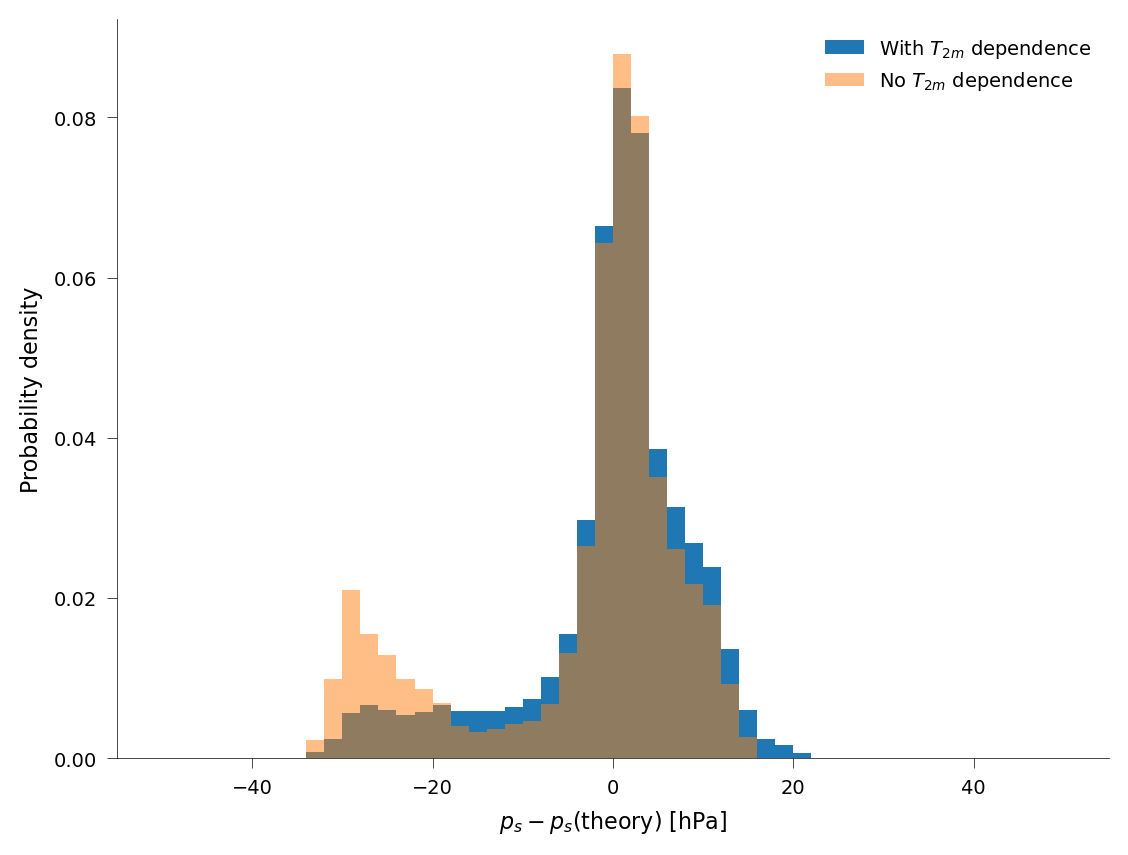

In [8]:
# plt.scatter(ds[0].PS, ps_theory, s=1)
# plt.scatter(ds[0].PS, ps_theory_just_z, s=1)
# plt.scatter(z2m.values.flatten(), ds[0].PS.values.flatten()-ps_theory.values.flatten(), c=land)
plt.hist((ds[0].PS.values.flatten()-ps_theory.values.flatten())/100, bins=np.linspace(-50, 50, 51), label='With $T_{2m}$ dependence', density=True)
plt.hist((ds[0].PS.values.flatten()-ps_theory_just_z.values.flatten())/100, bins=np.linspace(-50, 50, 51), alpha=0.5,
         label='No $T_{2m}$ dependence', density=True)
plt.legend()
plt.xlabel('$p_s - p_s$(theory) [hPa]')
plt.ylabel('Probability density')
plt.show()
# plt.plot([500*100, 1100*100], [500*100, 1100*100])

## Reconstructing $T_{2m}$
First I do a sanity check that with the actual pressure, the equation reconstructs the exact $T_{2m}$.

In [9]:
show_plot = False
i = 0
var = reconstruct_temp(ds[i].T, ds[i].PS, ds[i].p_at_lcl, 500*100, ds[i].lapse_below_lcl/1000, ds[i].lapse_above_lcl/1000)
if show_plot:
    np.abs(var-ds[i].TREFHT).plot(vmin=0, vmax=2)
    plt.show()
print(f"{float(np.abs(var-ds[i].TREFHT).quantile(0.99)):.3g}")

2.16e-12


### With approx $p_s$
Below I use the approx surface pressure with only $z$ dependence, to show that the reconstructed $T_{2m}$ and change with warming $\delta T_{2m}$ is pretty small.

In [10]:
for i in range(n_exp):
    ds[i]['TREFHT_recon'] = reconstruct_temp(ds[i].T, ps_theory_just_z, ds[i].p_at_lcl, 500*100,
                                             ds[i].lapse_below_lcl/1000, ds[i].lapse_above_lcl/1000)

In [11]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.arange(40, 70, 25)):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    return ax

def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=land, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

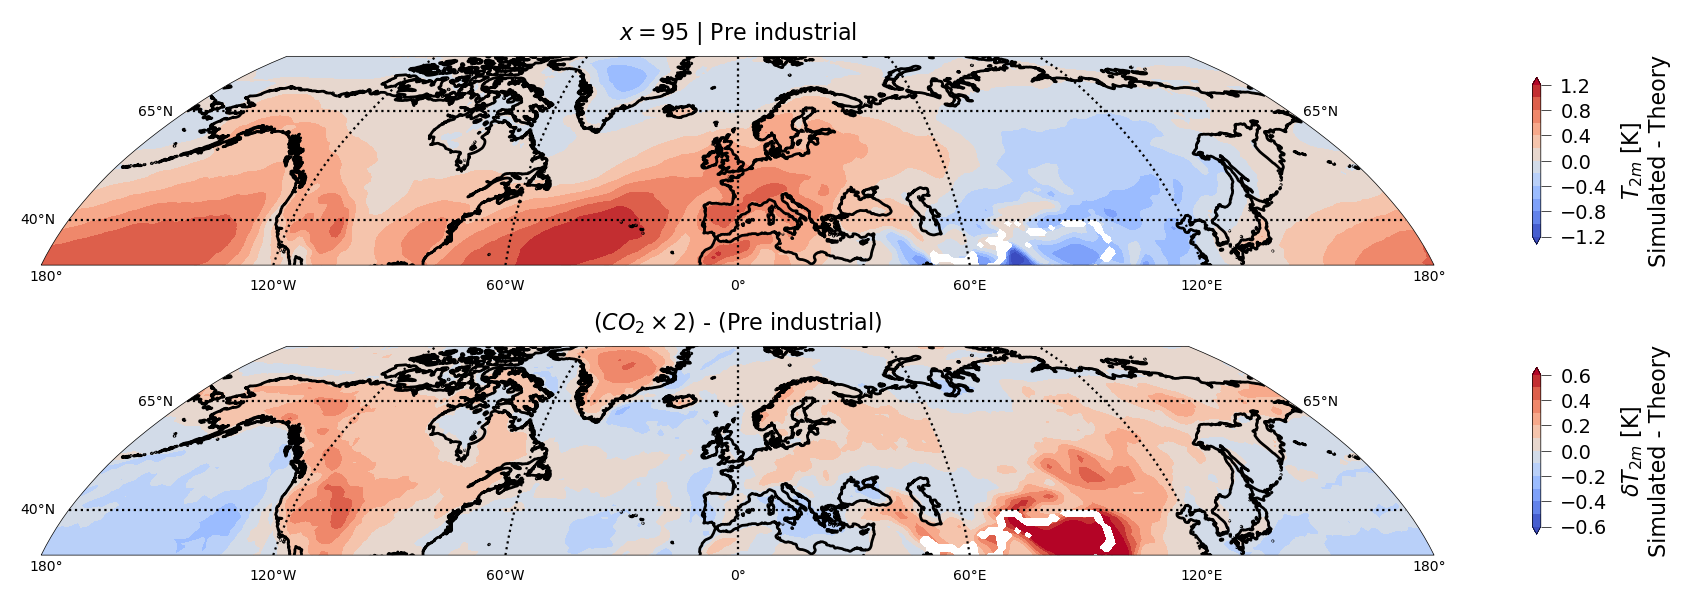

In [12]:
fig = plt.figure(constrained_layout=True,figsize=(10.,2.9))
ax = fig.subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0])
initialize_ax_projection(ax[1])

im = plot_contour_projection(ax[0], ds[0].TREFHT-ds[0].TREFHT_recon, levels=np.arange(-1.2, 1.3, 0.2), cmap='coolwarm', mask=None)
fig.colorbar(shrink=0.8, ax=ax[0], label='$T_{2m}$ [K]\nSimulated - Theory', mappable=im)
im = plot_contour_projection(ax[1], (ds[1].TREFHT-ds[0].TREFHT) - (ds[1].TREFHT_recon-ds[0].TREFHT_recon),
                             levels=np.arange(-0.6, 0.7, 0.1), cmap='coolwarm', mask=None)
fig.colorbar(shrink=0.8, ax=ax[1], label='$\delta T_{2m}$ [K]\nSimulated - Theory', mappable=im)
ax[0].set_title(f'$x={quant}$ | {exp_labels[0]}')
ax[1].set_title(f'({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

## Simulated change in REFHT Temperature
Below we see arctic amplification to some degree over North America and Russia.

## Equation for $T_{2m}$
Below, I compute the equation for $T_{2m}$ from the lapse rates and LCL levels.

The first method is just $T_{2m} = T_{500} + \Gamma_{<LCL} (z_{LCL} - z_{2m}) + \Gamma_{>LCL} (z_{500}-z_{LCL})$. And then use the Zhang formula to relate $T_{500} = \overline{T_{500}}/ \overline{z_{500}} z_{500}$. So $T_{2m}$ only depends on $T_{500}, \Gamma_{<LCL}, z_{LCL}, \Gamma_{>LCL}$.

The second method works exclusively in pressure coordinates, arising from just hydrostatic eqb, ideal gas law and assuming constant lapse rate both between 2m and LCL, and between LCL and 500hPa. This gives:

$\ln(\frac{p_s}{p_{LCL}}) = \frac{g}{R\Gamma_1}\ln(\frac{T_{2m}}{T_{LCL}})$ and $\ln(\frac{p_{LCL}}{p_{500}}) = \frac{g}{R\Gamma_2}\ln(\frac{T_{LCL}}{T_{500}})$

Which can be combined to give:

$$T_{2m} = T_{500}\left(p_s^{\Gamma_1} p_{500}^{-\Gamma_2} p_{LCL}^{\Gamma_2 - \Gamma_1}\right)^{R/g} =
T_{500}\left((p_s/p_{LCL})^{\Gamma_1-\Gamma_2}(p_s/p_{500})^{\Gamma_2}\right)^{R/g}$$

I think this method makes more sense, as never involves $z_{500}$, and can then simplify by assuming $p_s$ just depends on surface geopotential height. And can also write in terms of $p_{LCL}/p_s$ which is what formula for LCL gives. Where $\Gamma_1 = \Gamma_{<LCL}$ and $\Gamma_2 = \Gamma_{>LCL}$.

In [13]:
TREFHT_change_breakdown_change = {'T500': ds[1].T-ds[0].T, 'lapse_below_lcl': ds[1].lapse_below_lcl - ds[0].lapse_below_lcl,
                                  'lapse_above_lcl': ds[1].lapse_above_lcl - ds[0].lapse_above_lcl,
                                  'p_lcl': ds[1].p_lcl/ds[1].PS - ds[0].p_lcl/ds[0].PS,
                                  'p_s': ds[1].plev/ds[1].PS - ds[0].plev/ds[0].PS}
TREFHT_change_breakdown_sensitivity = {'T500': ds[0].TREFHT/ds[0].T,
                                       'lapse_below_lcl': -ds[0].TREFHT * np.log(ds[0].p_lcl/ds[0].PS) * R/g / 1000,
                                       'lapse_above_lcl': ds[0].TREFHT * np.log(ds[0].p_lcl/ds[0].plev) * R/g / 1000,
                                       'p_lcl': R/g * (ds[0].lapse_above_lcl-ds[0].lapse_below_lcl)/1000 * ds[0].PS/ds[0].p_lcl * ds[0].TREFHT,
                                       'p_s': -R/g * ds[0].lapse_above_lcl/1000 * ds[0].PS/ds[0].plev * ds[0].TREFHT}
TREFHT_change_breakdown_cont = {key: TREFHT_change_breakdown_change[key] * TREFHT_change_breakdown_sensitivity[key]
                              for key in TREFHT_change_breakdown_change}
TREFHT_change_theory = sum(TREFHT_change_breakdown_cont.values())

In [14]:
def get_var_av(var, lat_min=30, lat_max=80, mask=land):
    return var.where(mask>0).sel(lat=slice(lat_min, lat_max)).mean()

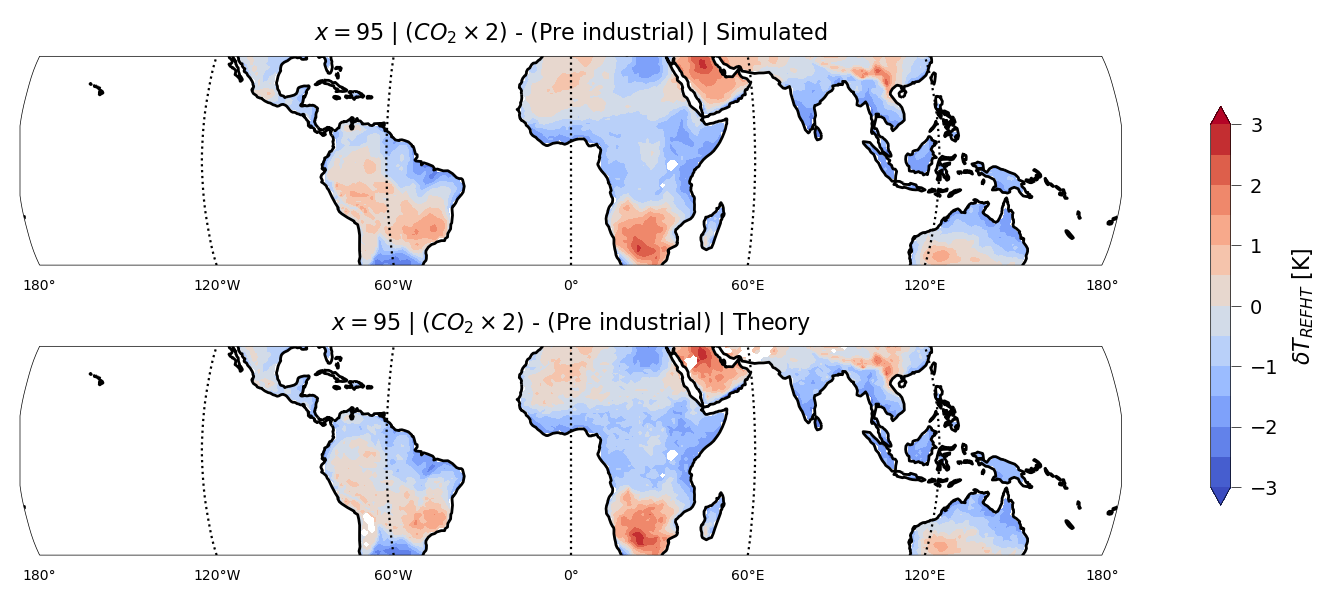

In [15]:
lat_plot_min = -30
lat_plot_max = 30
norm_by_av = 'FT'
levels_temp_change = {False: np.arange(2, 12, 1) if lat_plot_min>0 else np.arange(4, 8, 0.5), True: np.arange(-3, 3.5, 0.5)}
fig = plt.figure(constrained_layout=True,figsize=(10.,2.9))
ax = fig.subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)

var = ds[1].TREFHT - ds[0].TREFHT
if norm_by_av == 'FT':
    var = var - TREFHT_change_breakdown_cont['T500']
    var_theory = TREFHT_change_theory - TREFHT_change_breakdown_cont['T500']
    norm_by_av = True
else:
    var = var - float(norm_by_av)*get_var_av(var, lat_plot_min, lat_plot_max)
    var_theory = TREFHT_change_theory - float(norm_by_av)*get_var_av(var, lat_plot_min, lat_plot_max)

plot_contour_projection(ax[0], var, levels=levels_temp_change[norm_by_av],
                        cmap='coolwarm' if norm_by_av else 'viridis')
im = plot_contour_projection(ax[1], var_theory,
                             levels=levels_temp_change[norm_by_av],
                             cmap='coolwarm' if norm_by_av else 'viridis')
fig.colorbar(shrink=0.8, ax=ax, label='$\delta T_{REFHT}$ [K]', mappable=im)
ax[0].set_title(f'$x={quant}$ | ({exp_labels[1]}) - ({exp_labels[0]}) | Simulated')
ax[1].set_title(f'$x={quant}$ | ({exp_labels[1]}) - ({exp_labels[0]}) | Theory')
plt.show()

In [16]:
levels_breakdown = {'change': {'p_lcl': np.arange(-0.1, 0.11, 0.01), 'p_s': np.arange(-0.01, 0.011, 0.001),
                               'T500': levels_temp_change[False], 'lapse_below_lcl': np.arange(-4, 5, 1),
                               'lapse_above_lcl': np.arange(-0.4, 0.5, 0.1)},
                   'sensitivity': {'p_lcl': np.arange(-150, 155, 10), 'p_s': np.arange(-140, -30, 10),
                                   'T500': np.arange(1, 1.18, 0.01),
                                   'lapse_below_lcl': np.arange(0, 4.5, 0.5), 'lapse_above_lcl': np.arange(1, 6, 0.2)},
                   'cont': {key: levels_temp_change[False] if key=='T500' else levels_temp_change[True]
                            for key in TREFHT_change_breakdown_cont}}
units_breakdown = {'change': {'p_lcl': 'Pa/Pa', 'p_s': 'Pa/Pa', 'T500': 'K', 'lapse_below_lcl': 'K/km', 'lapse_above_lcl': 'K/km'},
                   'sensitivity': {'p_lcl': 'K', 'p_s': 'K', 'T500': 'K/K', 'lapse_below_lcl': 'km', 'lapse_above_lcl': 'km'}}
name_breakdown = {'T500': '$T_{500}$', 'p_lcl': '$\sigma_{LCL}$', 'p_s': '$\sigma_{500}$', 'lapse_below_lcl': '$\Gamma_{<LCL}$',
                  'lapse_above_lcl': '$\Gamma_{>LCL}$'}
def has_multiple_signs(arr):
    arr = np.asarray(arr)
    return np.any(arr > 0) and np.any(arr < 0)

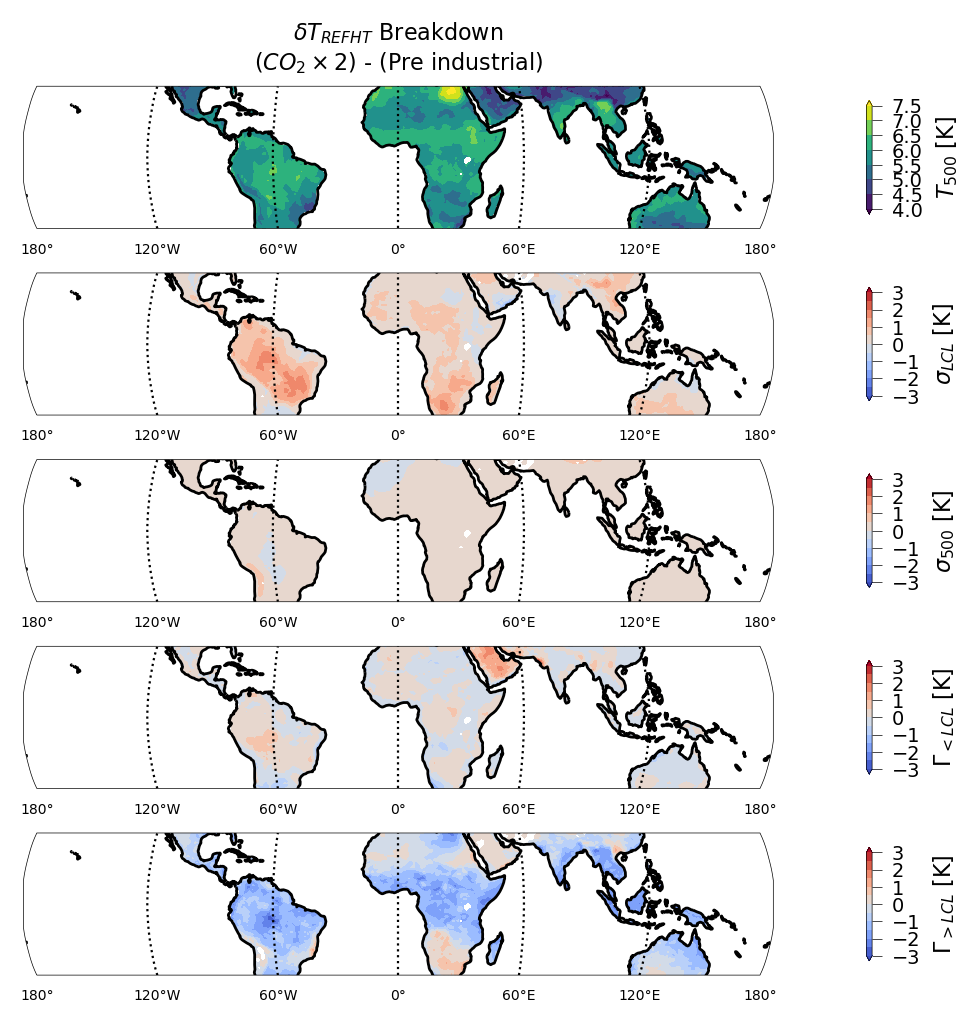

In [17]:
fig = plt.figure(constrained_layout=True,figsize=(10.,5))
ax = fig.subplots(5,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
for i, key in enumerate(name_breakdown):
    initialize_ax_projection(ax[i], lat_min=lat_plot_min, lat_max=lat_plot_max)
    im = plot_contour_projection(ax[i], TREFHT_change_breakdown_cont[key],
                             cmap='coolwarm' if has_multiple_signs(levels_breakdown['cont'][key]) else 'viridis',
                             levels=levels_breakdown['cont'][key])
    fig.colorbar(shrink=0.8, ax=ax[i], label=f'{name_breakdown[key]} [K]', mappable=im)
ax[0].set_title(f'$\delta T_{"{REFHT}"}$ Breakdown\n({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

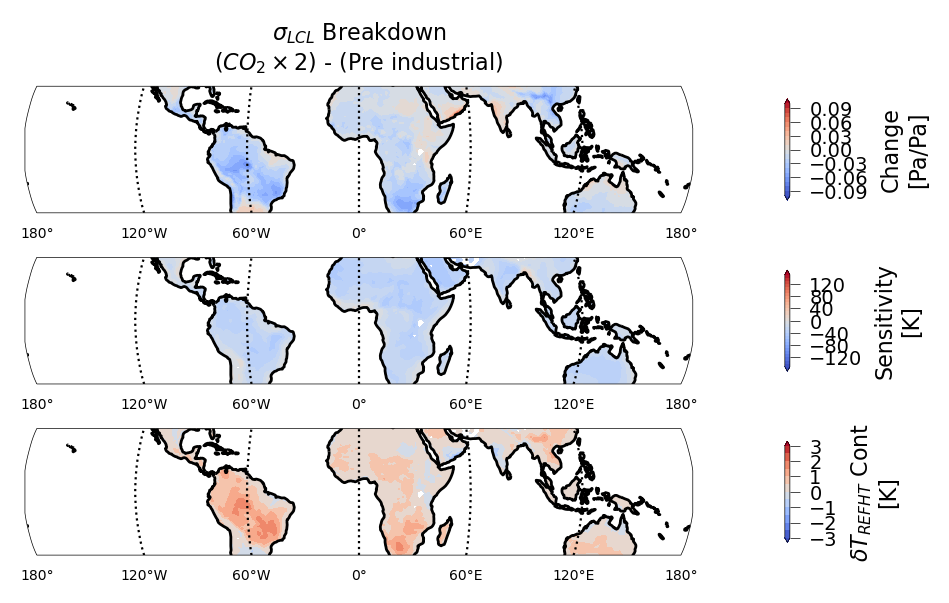

In [18]:
key = 'p_lcl'
fig = plt.figure(constrained_layout=True,figsize=(10.,2.9))
ax = fig.subplots(3,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[1], lat_min=lat_plot_min, lat_max=lat_plot_max)
initialize_ax_projection(ax[2], lat_min=lat_plot_min, lat_max=lat_plot_max)
im = plot_contour_projection(ax[0], TREFHT_change_breakdown_change[key], levels=levels_breakdown['change'][key],
                             cmap='coolwarm' if has_multiple_signs(levels_breakdown['change'][key]) else 'viridis')
fig.colorbar(shrink=0.8, ax=ax[0], label=f'Change\n[{units_breakdown["change"][key]}]', mappable=im)
im = plot_contour_projection(ax[1], TREFHT_change_breakdown_sensitivity[key], levels=levels_breakdown['sensitivity'][key],
                             cmap='coolwarm' if has_multiple_signs(levels_breakdown['sensitivity'][key]) else 'viridis')
fig.colorbar(shrink=0.8, ax=ax[1], label=f'Sensitivity\n[{units_breakdown["sensitivity"][key]}]', mappable=im)
im = plot_contour_projection(ax[2], TREFHT_change_breakdown_cont[key],
                             cmap='coolwarm' if has_multiple_signs(levels_breakdown['cont'][key]) else 'viridis',
                             levels=levels_breakdown['cont'][key])
fig.colorbar(shrink=0.8, ax=ax[2], label='$\delta T_{REFHT}$ Cont\n[K]', mappable=im)
ax[0].set_title(f'{name_breakdown[key]} Breakdown\n({exp_labels[1]}) - ({exp_labels[0]})')
plt.show()

### Quantify Error between profiles
For each model level, we compute the max error between the environmental profile temperature and that obtained along the two constant lapse rates above and below the LCL.

In [19]:
p_levels_prof = []
temp_prof_below_lcl_const_lapse = []
temp_prof_above_lcl_const_lapse = []
for i in range(n_exp):
    p_levels_prof.append(isca_tools.cesm.get_pressure(pressure_surf[i], p0, hyam, hybm))
    if surf_model_level is not None:
        p_levels_prof[i] = p_levels_prof[i].isel(lev=slice(0, surf_model_level+1))

    temp_prof_below_lcl_const_lapse.append(reconstruct_temp(ds[i].TREFHT, p_levels_prof[i], p_levels_prof[i], ds[i].PS,
                                           ds[i].lapse_below_lcl/1000, ds[i].lapse_below_lcl/1000).where(p_levels_prof[i] >= ds[i].p_at_lcl))

    temp_prof_above_lcl_const_lapse.append(reconstruct_temp(ds[i].T_at_lcl, p_levels_prof[i], p_levels_prof[i], ds[i].p_at_lcl,
                                           ds[i].lapse_above_lcl/1000, ds[i].lapse_above_lcl/1000).where(p_levels_prof[i] < ds[i].p_at_lcl))
    temp_prof_above_lcl_const_lapse[i] = temp_prof_above_lcl_const_lapse[i].where(p_levels_prof[i] >= float(ds[i].plev))

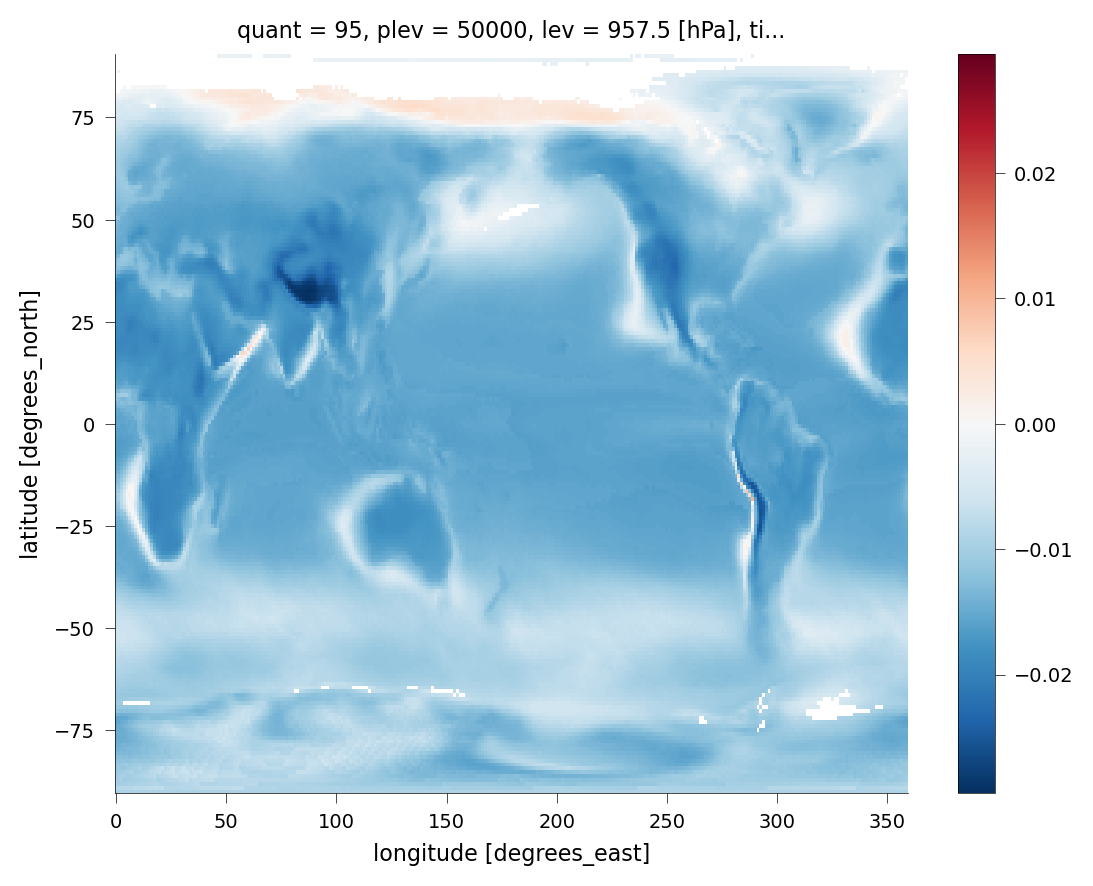

In [20]:
# Sanity check that reconstructed TREFHT correct
i = 0
(temp_prof_below_lcl_const_lapse[i].isel(lev=-1) - ds[i].TREFHT).plot()

In [21]:
temp_prof = []
for i in tqdm(range(n_exp)):
    temp_prof.append(xr.load_dataset(f"{exp_path_prof}/T/{exp_name[i]}/output.nd2").T.sel(quant=quant))
    if surf_model_level is not None:
        temp_prof[i] = temp_prof[i].isel(lev=slice(0, surf_model_level+1))

  0%|          | 0/2 [00:00<?, ?it/s]

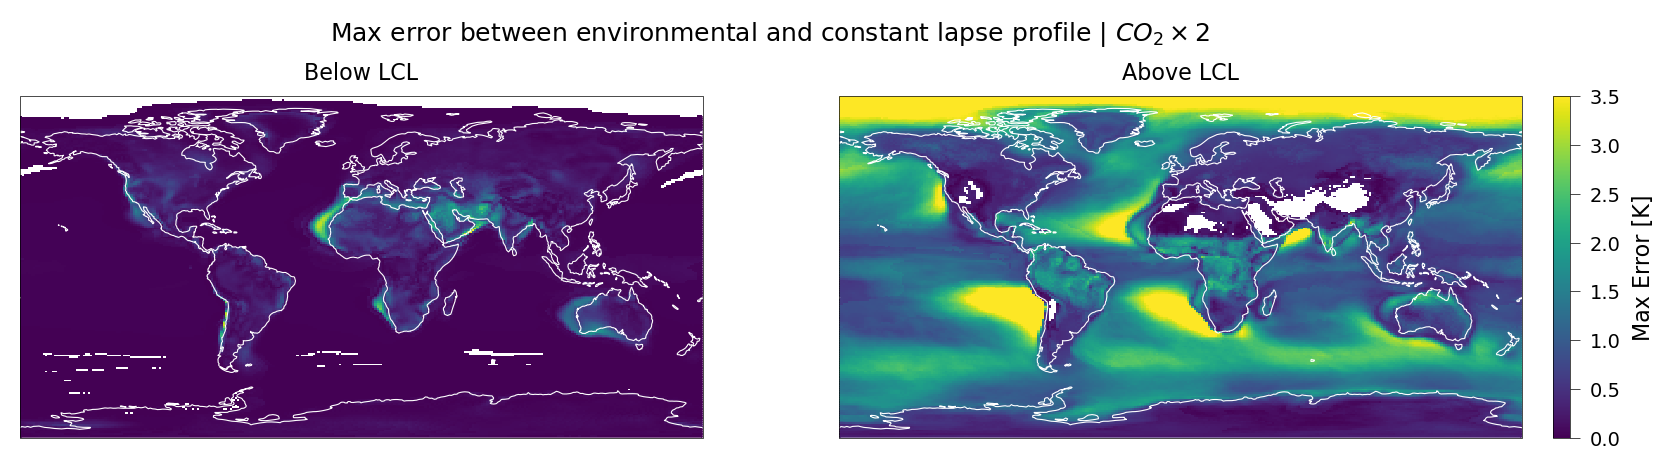

In [22]:
i = 1
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
ax[0].pcolormesh(ds[0].lon, ds[0].lat, np.abs(temp_prof[i] - temp_prof_below_lcl_const_lapse[i]).max(dim='lev'), vmin=0, vmax=3.5)
im = ax[1].pcolormesh(ds[0].lon, ds[0].lat, np.abs(temp_prof[i] - temp_prof_above_lcl_const_lapse[i]).max(dim='lev'), vmin=0, vmax=3.5)
plt.colorbar(im, ax=ax.ravel(), fraction=0.011, pad=0.02, label='Max Error [K]')
for j in range(len(ax)):
    ax[j].coastlines(lw=0.4, color='w')
ax[0].set_title('Below LCL')
ax[1].set_title('Above LCL')
fig.suptitle(f'Max error between environmental and constant lapse profile | {exp_labels[i]}', y=0.66, fontsize=9)
plt.show()

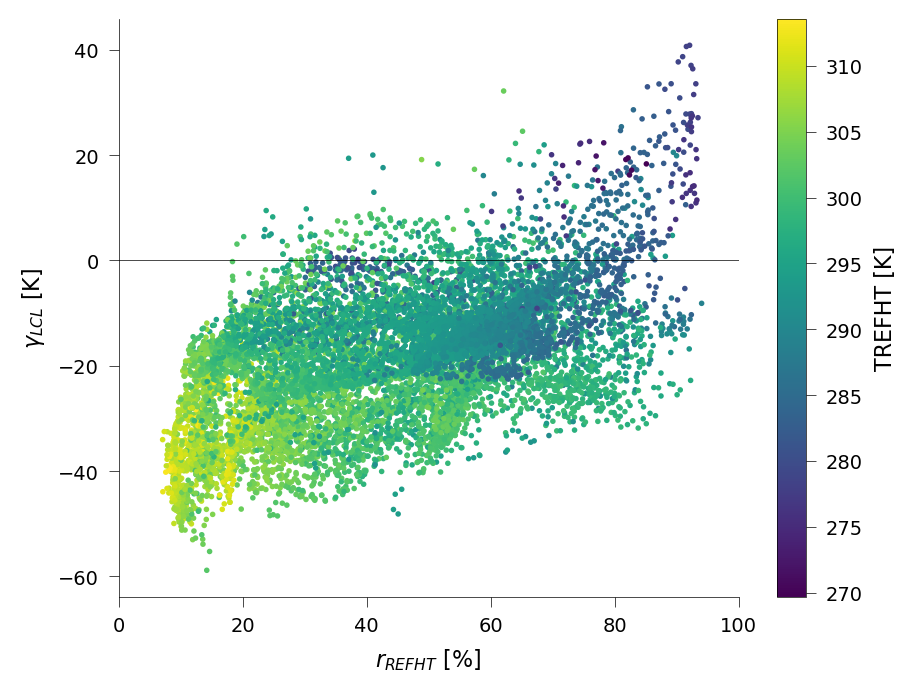

In [64]:
lat_min = -50
lat_max = 65
mask = land.where(land.lat>=lat_min).where(land.lat<=lat_max)
ax_linewidth = plt.rcParams['axes.linewidth']
fig, ax = plt.subplots(1,1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
im = ax.scatter(ds[0].QREFHT/sphum_sat(ds[0].TREFHT, ds[0].PS) * mask * 100, TREFHT_change_breakdown_sensitivity['p_lcl'] * mask,
                s=1, c=ds[0].TREFHT)
plt.colorbar(im, ax=ax, label='TREFHT [K]')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel('$r_{REFHT}$ [%]')
ax.set_ylabel('$\gamma_{LCL}$ [K]')
ax.set_xlim(0, 100)
plt.show()

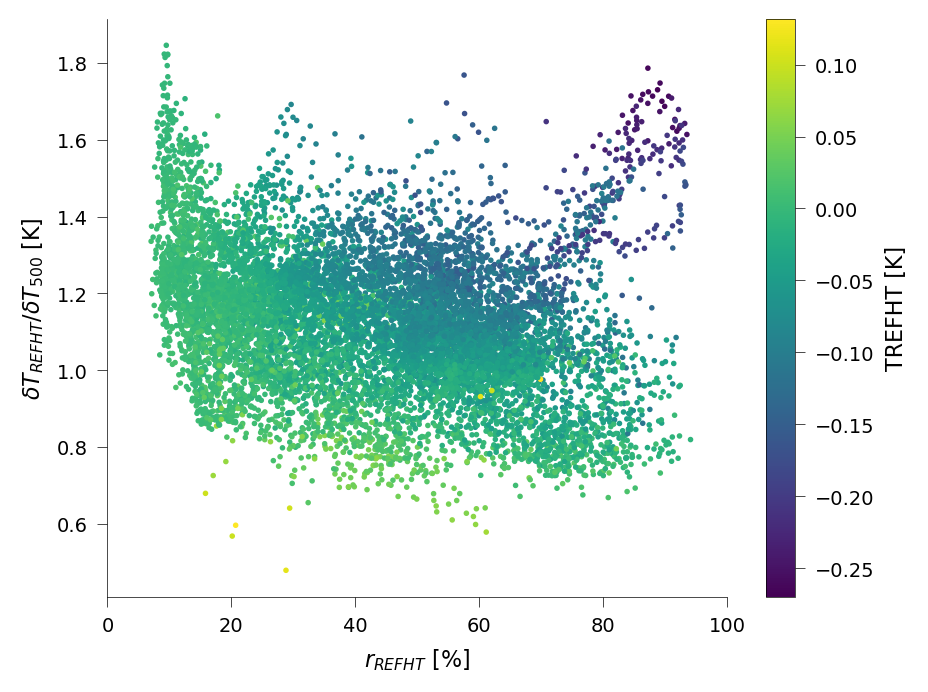

In [61]:
fig, ax = plt.subplots(1,1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
im = ax.scatter(ds[0].QREFHT/sphum_sat(ds[0].TREFHT, ds[0].PS) * mask * 100, (ds[1].TREFHT - ds[0].TREFHT)/(ds[1].T-ds[0].T) * mask,
                s=1, c=ds[1].QREFHT/sphum_sat(ds[1].TREFHT, ds[1].PS) - ds[0].QREFHT/sphum_sat(ds[0].TREFHT, ds[0].PS))
plt.colorbar(im, ax=ax, label='TREFHT [K]')
ax.set_xlabel('$r_{REFHT}$ [%]')
ax.set_ylabel('$\delta T_{REFHT}/\delta T_{500}$ [K]')
ax.set_xlim(0, 100)
plt.show()

In [74]:
[TREFHT_change_breakdown_cont[key] for key in ['T500', 'p_lcl']]

[<xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
 array([[4.84371872, 4.84374888, 4.84374712, ..., 4.84375099, 4.84374712,
         4.84374712],
        [5.02049544, 5.00919536, 4.98858595, ..., 5.01767857, 5.00740823,
         5.01094853],
        [5.37343474, 5.35640573, 5.35896791, ..., 5.34787469, 5.36144742,
         5.36020941],
        ...,
        [4.97027413, 4.97518554, 4.94265858, ..., 4.95696539, 4.96016467,
         4.98135952],
        [4.91922544, 4.92994074, 4.92661519, ..., 4.8380162 , 4.87918556,
         4.90403984],
        [5.08384685, 5.08383395, 5.08384666, ..., 5.06757655, 5.08127898,
         5.08127841]])
 Coordinates:
     quant    int64 8B 95
   * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
     plev     int64 8B 50000
     lev      float64 8B 957.5
     time     object 8B 0031-01-02 00:00:00,
 <xarray.DataArray (lat: 192, lon: 288)> Size: 442

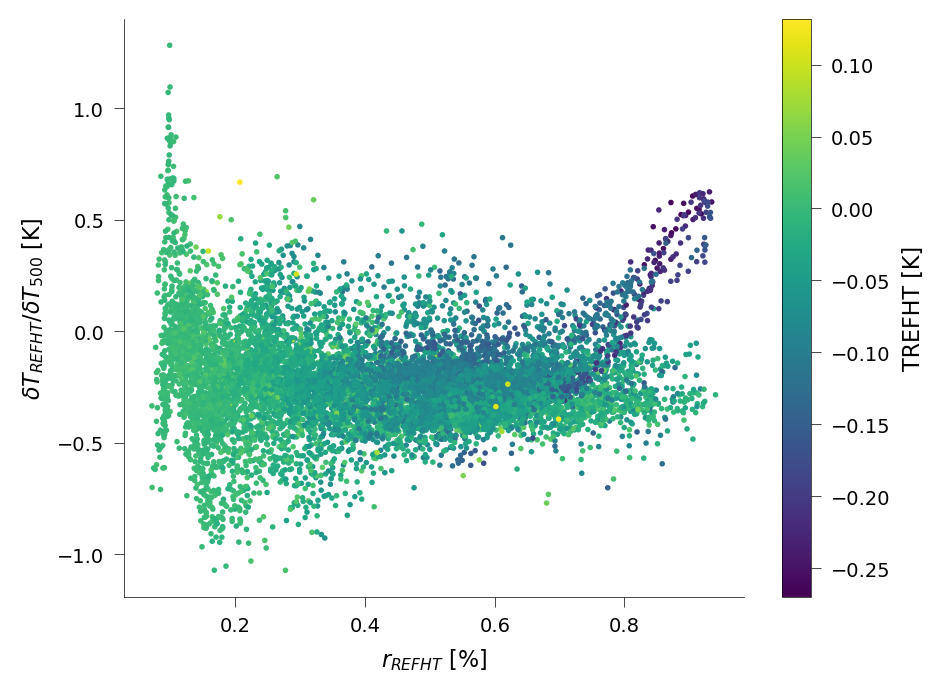

In [105]:
fig, ax = plt.subplots(1,1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
im = ax.scatter(ds[0].QREFHT/sphum_sat(ds[0].TREFHT, ds[0].PS) * mask, TREFHT_change_breakdown_change['lapse_above_lcl'] * mask,
                s=1, c=ds[1].QREFHT/sphum_sat(ds[1].TREFHT, ds[1].PS) - ds[0].QREFHT/sphum_sat(ds[0].TREFHT, ds[0].PS))
plt.colorbar(im, ax=ax, label='TREFHT [K]')
ax.set_xlabel('$r_{REFHT}$ [%]')
ax.set_ylabel('$\delta T_{REFHT}/\delta T_{500}$ [K]')
# ax.set_xlim(0, 100)
# ax.set_ylim(-0.5, 0.5)
plt.show()

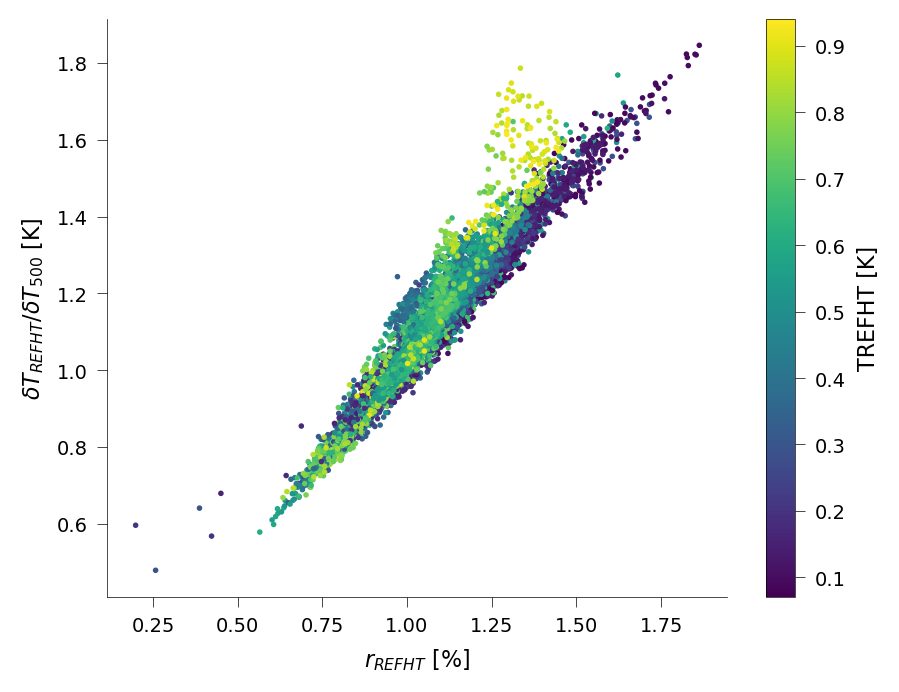

In [89]:
fig, ax = plt.subplots(1,1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
im = ax.scatter(sum([TREFHT_change_breakdown_cont[key] for key in ['T500', 'lapse_above_lcl', 'p_lcl', 'lapse_below_lcl']])/(ds[1].T-ds[0].T) * mask, (ds[1].TREFHT - ds[0].TREFHT)/(ds[1].T-ds[0].T) * mask,
                s=1, c=ds[0].QREFHT/sphum_sat(ds[0].TREFHT, ds[0].PS))
plt.colorbar(im, ax=ax, label='TREFHT [K]')
ax.set_xlabel('$r_{REFHT}$ [%]')
ax.set_ylabel('$\delta T_{REFHT}/\delta T_{500}$ [K]')
# ax.set_xlim(0, 100)
plt.show()

c### Example Temperature Profiles

In [23]:
exp_path_prof = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/av_profile/above_TREFHTquant'
ds_prof = []
for i in tqdm(range(n_exp)):
    ds_prof.append(xr.load_dataset(f"{exp_path_prof}/T/{exp_name[i]}/output.nd2")[['T']])
    ds_prof[i]['PS'] = xr.load_dataset(exp_path[i])['PS']     # need PS to compute pressure levels

  0%|          | 0/2 [00:00<?, ?it/s]

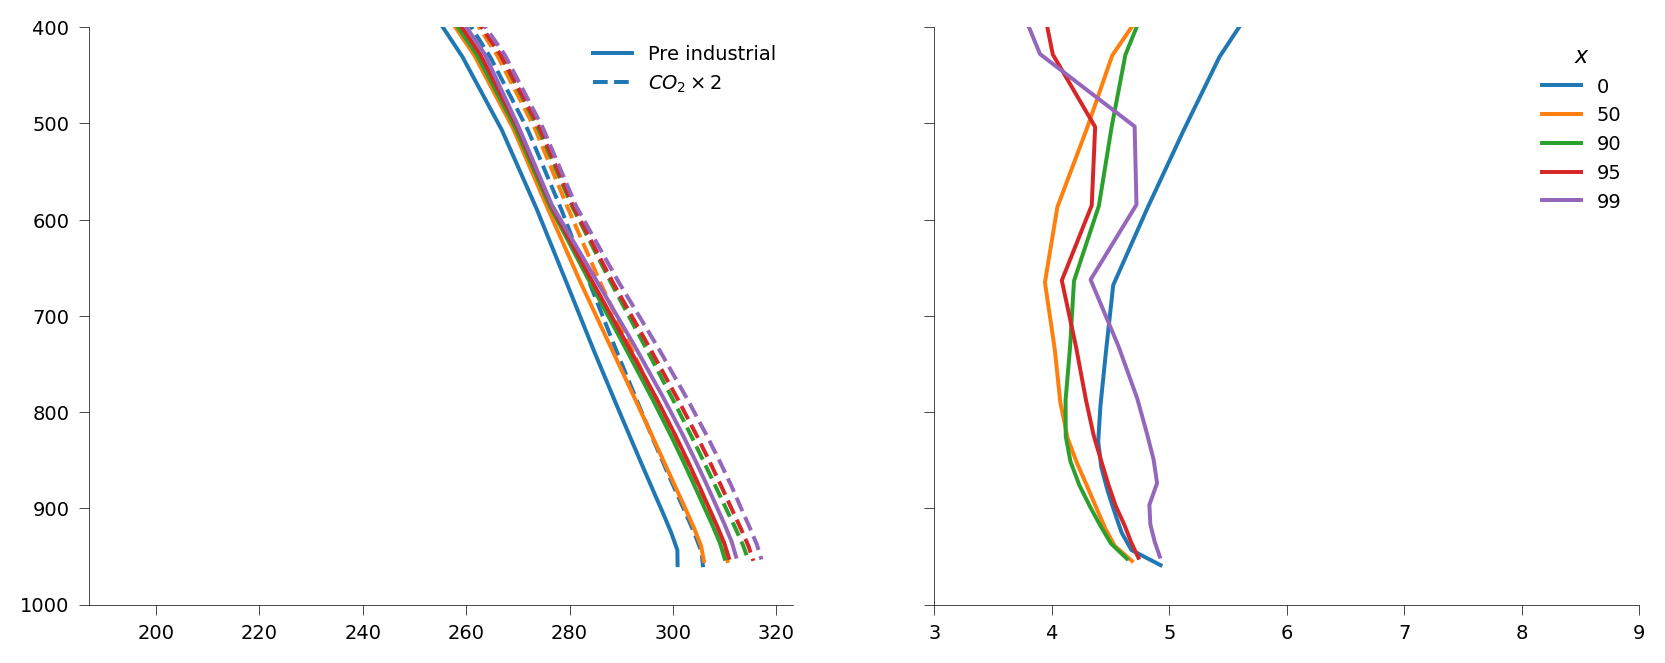

In [24]:
lat_prof = 25
lon_prof = 77.5
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 10)
for i in range(0, ds_prof[0].quant.size):
    ds_use = [ds_prof[j].isel(quant=i).sel(lat=lat_prof, lon=lon_prof, method='nearest') for j in range(n_exp)]
    for j in range(n_exp):
        ax[0].plot(ds_use[j].T, isca_tools.cesm.get_pressure(ds_use[j].PS, p0, hyam, hybm)/100, color=f'C{i}',
                 linestyle='--' if j==1 else None, label=exp_labels[j] if i==0 else None)
    ax[1].plot(ds_use[1].T-ds_use[0].T, isca_tools.cesm.get_pressure(ds_use[0].PS, p0, hyam, hybm)/100, color=f'C{i}',
               label=f'{ds_use[0].quant:.0f}')
ax[0].invert_yaxis()
ax[0].set_ylim(1000, 400)
ax[1].set_xlim(3, 9)
update_linewidth(fig)
ax[0].legend()
ax[1].legend(title='$x$')
plt.show()